In [5]:
import numpy as np
import pymc3 as pm
import theano as th
import theano.tensor as tt
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

from plotutils import addtxt
mpl.style.use(['./scripts/theme_bw.mplstyle', './scripts/presentation.mplstyle'])

We consider the example 4 of Chapter 3: Amplitude of a signal in the presence of background.

The signal is assumed to be a Gaussian, width $w$ and centered at $x_0$, with the ideal datum $D_k$
\begin{align}
D_k &= n_0\left[A e^{-(x-x_0)^2/2 w^2} + B\right]
\end{align}
with $n_0$ a constant related to the measurement time.

The number of counts for $k$-th channel is assumed to be given the a Poisson distribution
\begin{align}
P(N_k| A, B, I) &= \frac{D_k^{N_k} e^{-D_k}}{N_k!}
\end{align}

Given the data count for each channel, what is the best estimate for $A$ and $B$?

In [6]:
def normal(x, mu, sig):
    return np.exp(-(x-mu)**2/(2*sig**2))
Areal, Breal = 1.0, 2.0
μreal, σreal = 0.0, 5.0/(2*np.sqrt(2*np.log(2))) # fwhm = 5

In [7]:
def sample(nmax, nbins): # sample data for each channel (bin), nmax = max(<N>)
    n0 = nmax / (Areal + Breal) # fix n0 so that max(<N>) = nmax
    x  = np.arange(-nbins, nbins+1, 1) 
    y  = n0*(Areal*normal(x, μreal, σreal) + Breal) 
    ys = np.random.poisson(y)
    return n0, x, y, ys
ns   = []
data = []
np.random.seed(12345)
for nmax,nbins in zip([100, 10, 100, 100], [7, 7, 15, 3]):
    n0,x,y,ys = sample(nmax, nbins)
    ns.append(n0)
    data.append(pd.DataFrame({'x':x, 'y':y, 'ys':ys}))

We tried to reproduce the data from Fig. 3.3 of the book. We consider 4 different setups, changing the number of data bins and the maximum expectation of counts.
Below we plot the measured (simulated) data, drawn from the Poisson distribution, together with the ideal data (given by the Gaussian). 

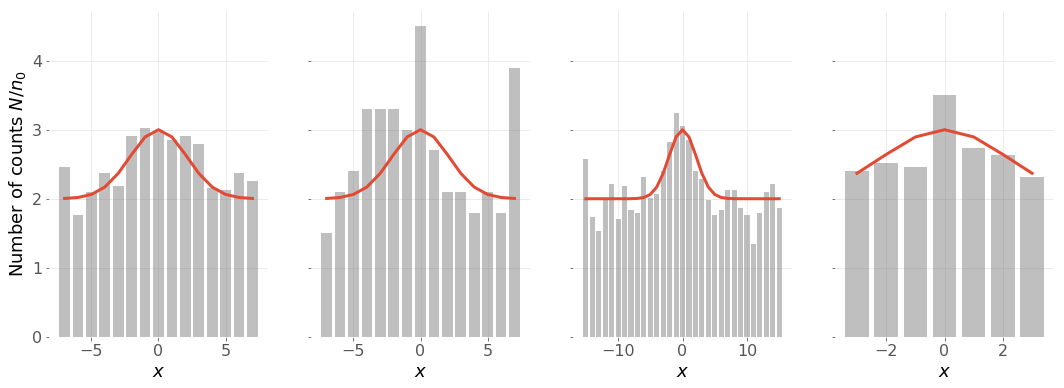

In [8]:
fig, axes = plt.subplots(figsize=(18,6), ncols=4, sharey=True)
for ax,n,df in zip(axes, ns, data):
    ax.plot(df['x'], df['y']/n) # ideal data
    ax.bar(df['x'], df['ys']/n, color='gray', alpha=0.5) # measured data
    ax.set_xlabel(r'$x$', fontsize=18)
axes[0].set_ylabel(r'Number of counts $N/n_0$', fontsize=18)
plt.show()

Now we run the MCMC to obtain the posteriors for $A$ and $B$

In [9]:
traces = []
for n,df in zip(ns, data):
    with pm.Model() as model:
        A = pm.Uniform('A', lower = 0, upper = 10)
        B = pm.Uniform('B', lower = 0, upper = 10)
        
        N = pm.Poisson('N', mu = n*(A*tt.exp(-(df['x'].values-μreal)**2/(2*σreal**2)) + B), observed = df['ys'].values)
        traces.append(pm.sample(10000, tune=15000, progressbar=True))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [B, A]
Sampling 2 chains: 100%|██████████| 50000/50000 [00:18<00:00, 2672.70draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [B, A]
Sampling 2 chains: 100%|██████████| 50000/50000 [00:18<00:00, 2635.47draws/s]
The acceptance probability does not match the target. It is 0.4210691336452727, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [B, A]
Sampling 2 chains: 100%|██████████| 50000/50000 [00:15<00:00, 3140.70draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [B, A]
Sampling 2 ch

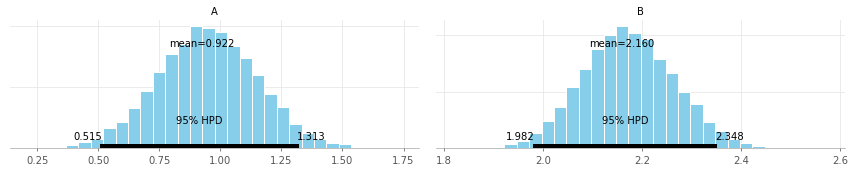

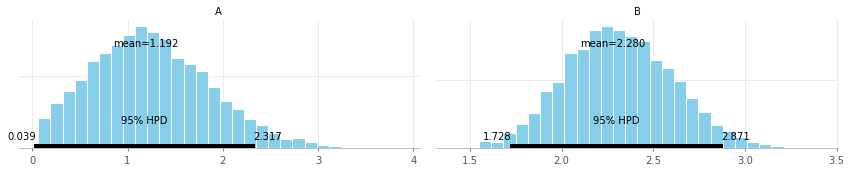

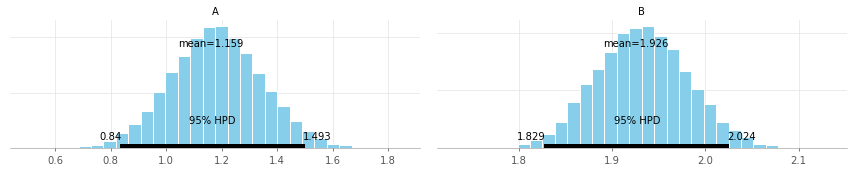

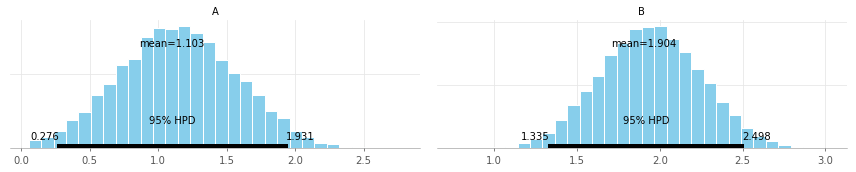

In [10]:
for trace in traces:
    pm.plot_posterior(trace, varnames=['A', 'B']); plt.show()

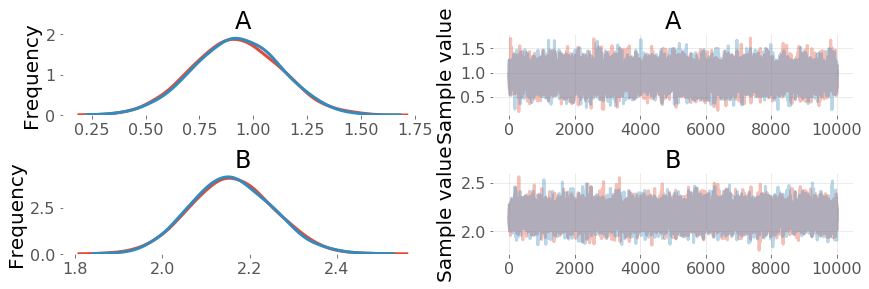

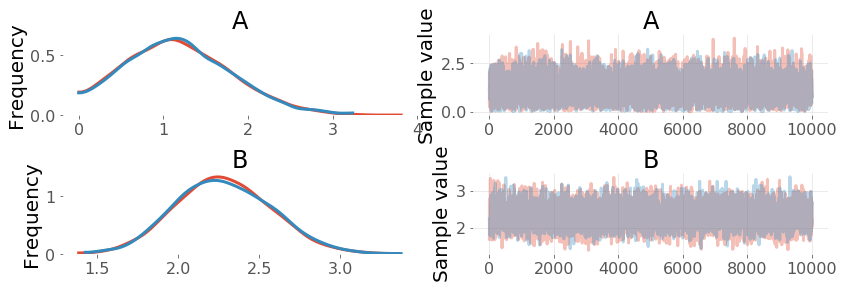

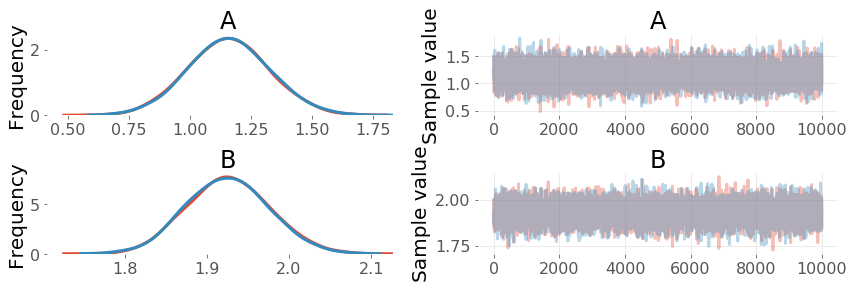

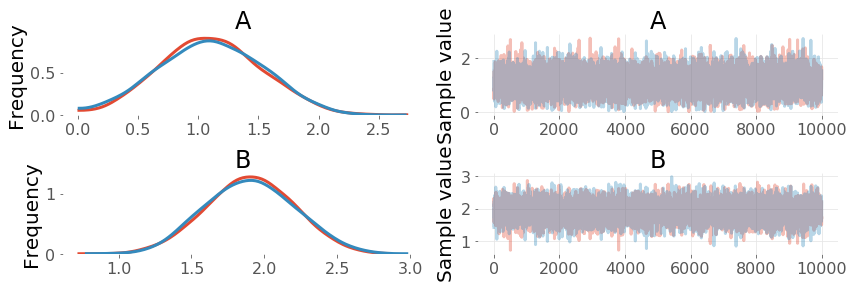

In [11]:
for trace in traces:
    pm.traceplot(trace, varnames=['A', 'B']); plt.show()

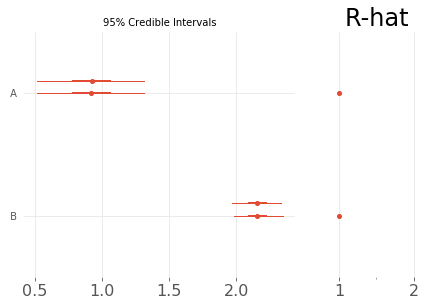

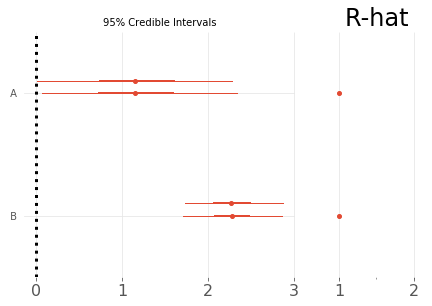

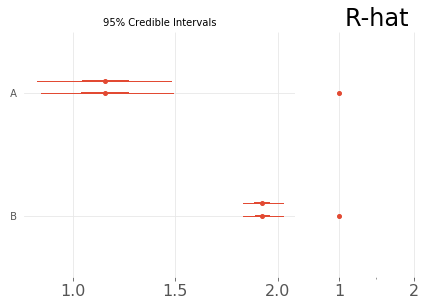

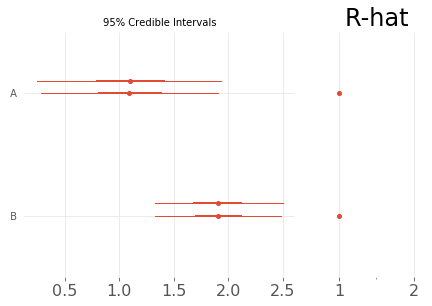

In [12]:
for trace in traces:
    pm.forestplot(trace, varnames=['A', 'B']); plt.show()

We now plot the contours of the posterior distribution, as well as the original measurement data

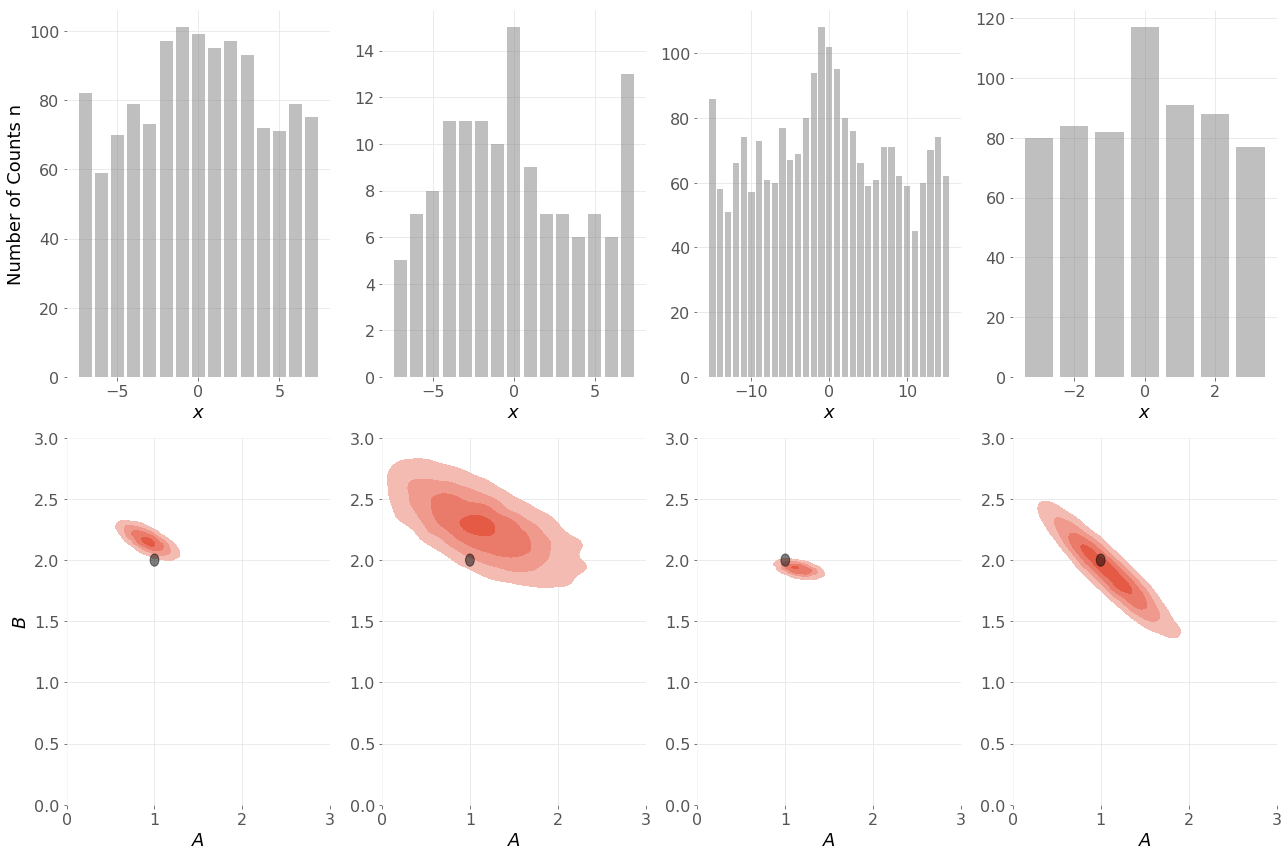

In [99]:
fig, axes = plt.subplots(figsize=(18,12), ncols=4, nrows=2)
for ax,df    in zip(axes[0], data):
    ax.bar(df['x'], df['ys'], color='gray', alpha=0.5)
    ax.set_xlabel(r'$x$', fontsize=18)
axes[0][0].set_ylabel(r'Number of Counts n', fontsize=18)

for ax,trace in zip(axes[1], traces):
    sns.kdeplot(trace['A'], trace['B'], shade=True, shade_lowest=False, n_levels=, ax = ax)
    ax.add_patch(plt.Circle((Areal, Breal), .05,  color='k', alpha=0.5))
    ax.set_xlabel(r'$A$', fontsize=18)
    ax.set_xlim(0,3)
    ax.set_ylim(0,3)
axes[1][0].set_ylabel(r'$B$', fontsize=18)
fig.tight_layout()